In [91]:
import numpy as np
from scipy import linalg
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
plt.rcParams['text.usetex'] = True


In [48]:
class statevector(np.ndarray): #extends the np.ndarray class to add functionalities like normalize, evolve under hamiltonian and also obtain density matrix
    def __new__(cls, input_array):
        obj = np.asarray(input_array, dtype=np.complex64).view(cls)
        return obj

    def H(self):
        return self.conj().T
    
    def get_norm(self):
        normVal = self.H()@self
        try:
            return normVal[0][0].real
        except:
            return normVal.real
    
    def normalize(self):
        if self.get_norm() != 0:
            self[:] = self/(self.get_norm()**0.5)
        return self
    
    def evolve(self, Hamiltonian, time, method='exact', dt=0):
        if method not in ['exact', 'trotter']:
            raise AttributeError(f"The specified method '{method}' does not exist.")
        
        if method == 'exact':
            evolvedstate = linalg.expm(-1j*Hamiltonian*time)@self
        else:
            size, __ = Hamiltonian.shape
            trotter_term = (operator(np.identity(size)) - 1j*Hamiltonian*dt)
            N = int(time/dt)
            evolvedstate = self
            for __ in range(N):
                evolvedstate = trotter_term@evolvedstate
            evolvedstate.view(statevector).normalize()
        
        self[:] = evolvedstate
        return self
    
    def get_rho(self):
        state = np.copy(self).view(statevector)
        state.normalize()
        rho = state@state.H()
        return rho.view(operator)
    
    
    def to_mathematica(self):
        string = '{'
        for row in self:
            string += '{'
            for element in row:
                string += str(element).replace('j', 'I') + ', '
            string = string[:-2] + '}, '
        string = string[:-2] + '}'
        return string


class operator(np.ndarray): #extends the np.ndarray class to add functionalities like expectation value of the operator for a given statevector
    def __new__(cls, input_array):
        obj = np.asarray(input_array, dtype=np.complex64).view(cls)
        return obj

    def H(self):
        return self.conj().T
    
    def expectation_value(self, state:statevector):
        state.normalize()
        exp_val =  state.H()@self@state
        try:
            return exp_val[0][0].real
        except:
            return exp_val.real
        
    
    def to_mathematica(self):
        string = '{'
        for row in self:
            string += '{'
            for element in row:
                string += str(element).replace('j', 'I') + ', '
            string = string[:-2] + '}, '
        string = string[:-2] + '}'
        return string

def natural_range(*args): #used to prevent confusions in coversion from natural index used in Hamiltonian and other Operators to python index
    '''
    natural_range(start, end) yields (i_p, i_n) where i_p is the programming index starting from start-1 to end-1 and i_n is the natural index starting from start to end. 
    'start' will default to 1 if natural_range is called with single arg.
    '''
    try:
        start = args[-2] - 1
    except:
        start = 0
    
    end = args[-1]
    
    for i in range(start, end):
        yield (i, i+1)


In [5]:
# basic defs
sx = operator([[0, 1],[1, 0]])
sy = operator([[0, -1j],[1j, 0]])
sz = operator([[1, 0],[0, -1]])
sp = (sx + 1j*sy)/2
sm = (sx - 1j*sy)/2
id_2 = operator(np.eye(2))

def Rx(theta:float) -> operator:
    return operator(linalg.expm(1j*theta*sx/2))
def Ry(theta:float) -> operator:
    return operator(linalg.expm(1j*theta*sy/2))
def Rz(theta:float) -> operator:
    return operator(linalg.expm(1j*theta*sz/2))


In [6]:
class VQE():
        def __init__(
                self, 
                init_state: statevector,
                hamiltonian: operator,
                seed:int=12731,
                optimizer: callable = None,
                lr_scheduler: callable = None
        ):
                super().__init__()
                self.state = init_state
                self.hamiltonian = hamiltonian
                self.N = int(np.log2(hamiltonian.shape[0]))

                np.random.seed(seed)
                thetas = np.random.uniform(low=0, high=4*np.pi, size=3*self.N)
                self.theta_x, self.theta_y, self.theta_z = thetas[:self.N], thetas[self.N:2*self.N], thetas[2*self.N:]

                self.momentum_x, self.momentum_y, self.momentum_z = np.zeros_like(self.theta_x), np.zeros_like(self.theta_y), np.zeros_like(self.theta_z)
                self.norm_x, self.norm_y, self.norm_z = np.zeros_like(self.theta_x), np.zeros_like(self.theta_y), np.zeros_like(self.theta_z)
                
                self.iters = 0

                self.lr_scheduler = lr_scheduler
                self.optimizer = optimizer

        def rotation_operator(
                self
        ) -> operator:
                theta_x_list = self.theta_x
                theta_y_list = self.theta_y
                theta_z_list = self.theta_z

                rotation_operator_list = [Rx(theta_x)@Ry(theta_y)@Rz(theta_z) for (theta_x, theta_y, theta_z) in zip(theta_x_list, theta_y_list, theta_z_list)]

                rotation_operator = rotation_operator_list[0]
                for op in rotation_operator_list[1:]:
                        rotation_operator = np.kron(rotation_operator, op)

                return operator(rotation_operator)
        
        def rotated_state(
                        self
        ):
                rotation_operator = self.rotation_operator()
                return statevector(rotation_operator@self.state)
        
        def get_energy(
                        self
        )-> float:
                hamiltonian = self.hamiltonian
                rotation_operator = self.rotation_operator()
                rotated_hamiltonian = rotation_operator.H() @ hamiltonian @ rotation_operator
                energy = rotated_hamiltonian.expectation_value(self.state)
                return energy
        
        def set_theta(
                        self,
                        theta_x,
                        theta_y,
                        theta_z
        ) -> None:
                self.theta_x[:], self.theta_y[:], self.theta_z[:] = theta_x, theta_y, theta_z

        def set_momentum(
                        self,
                        momentum_x,
                        momentum_y,
                        momentum_z
        ) -> None:
                self.momentum_x[:], self.momentum_y[:], self.momentum_z[:] = momentum_x, momentum_y, momentum_z

        def set_norm(
                        self,
                        norm_x,
                        norm_y,
                        norm_z
        ) -> None:
                self.norm_x[:], self.norm_y[:], self.norm_z[:] = norm_x, norm_y, norm_z
        
        def optimizer_step(
                        self
        ):
                init_energy = self.get_energy()
                max_grad = self.optimizer(self)
                self.iters += 1
                fin_energy = self.get_energy()
                if self.lr_scheduler is not None:
                        self.lr_scheduler(self)
                perc_change = abs(init_energy - fin_energy)*100/fin_energy
                return  fin_energy, perc_change, max_grad
        
        
        def get_gradients(
                        self
        ) -> tuple[list[float], list[float], list[float]]:
                theta_x, theta_y, theta_z = self.theta_x, self.theta_y, self.theta_z

                hamiltonian = self.hamiltonian
                state = self.state
                rotation_operator = self.rotation_operator()
                N = self.N

                d_theta_x, d_theta_y, d_theta_z = [], [], []

                d_theta_x_list = [[(1j/2)*sx@Rx(theta_x[i])@Ry(theta_y[i])@Rz(theta_z[i]) if i==j else Rx(theta_x[i])@Ry(theta_y[i])@Rz(theta_z[i]) for i in range(N)] for j in range(N)]
                d_theta_y_list = [[(1j/2)*Rx(theta_x[i])@sy@Ry(theta_y[i])@Rz(theta_z[i]) if i==j else Rx(theta_x[i])@Ry(theta_y[i])@Rz(theta_z[i]) for i in range(N)] for j in range(N)]
                d_theta_z_list = [[(1j/2)*Rx(theta_x[i])@Ry(theta_y[i])@sz@Rz(theta_z[i]) if i==j else Rx(theta_x[i])@Ry(theta_y[i])@Rz(theta_z[i]) for i in range(N)] for j in range(N)]

                for i in range(N):
                        temp = d_theta_x_list[i][0]
                        for op in d_theta_x_list[i][1:]:
                                temp = np.kron(temp, op)
                        d_theta_x.append(operator(temp))

                        temp = d_theta_y_list[i][0]
                        for op in d_theta_y_list[i][1:]:
                                temp = np.kron(temp, op)
                        d_theta_y.append(operator(temp))

                        temp = d_theta_z_list[i][0]
                        for op in d_theta_z_list[i][1:]:
                                temp = np.kron(temp, op)
                        d_theta_z.append(operator(temp))

                gradient_x, gradient_y, gradient_z = [], [], []

                for i in range(N):
                        gradient_x.append((rotation_operator.H() @ hamiltonian @ d_theta_x[i] + d_theta_x[i].H() @ hamiltonian @ rotation_operator).expectation_value(state))
                        gradient_y.append((rotation_operator.H() @ hamiltonian @ d_theta_y[i] + d_theta_y[i].H() @ hamiltonian @ rotation_operator).expectation_value(state))
                        gradient_z.append((rotation_operator.H() @ hamiltonian @ d_theta_z[i] + d_theta_z[i].H() @ hamiltonian @ rotation_operator).expectation_value(state))

                return gradient_x, gradient_y, gradient_z
        
        def exact_diagonalisation(self):
                e,v = np.linalg.eigh(self.hamiltonian)
                min_e = np.min(e)
                id = np.where(e == min_e)[0][0]
                return e[id], v[:,id]

In [7]:
class optimizers:
    def __init__(self, 
                learning_rate: float = 1e-3,
                beta:float = 0.1,
                gamma:float = 0.1, 
                inject_noise: bool = False,
                noise_level: float = 1e-3,

                min_learning_rate: float = 1e-4,
                max_learning_rate: float = 1e-1,
                total_iters: int = 0,
                ):
        self.learning_rate = learning_rate
        self.beta = beta
        self.gamma = gamma
        self.inject_noise = inject_noise
        self.noise_level = noise_level
        self.min_learning_rate = min_learning_rate
        self.max_learning_rate = max_learning_rate
        self.total_iters = total_iters

    def gd(
        self, 
        vqe
        )->tuple[float]:
                learning_rate = self.learning_rate

                theta_x, theta_y, theta_z = vqe.theta_x, vqe.theta_y, vqe.theta_z
                gradient_x, gradient_y, gradient_z = vqe.get_gradients()

                max_grad = max(max(map(abs, gradient_x)), max(map(abs, gradient_y)), max(map(abs, gradient_z)))

                theta_x[:] = [theta - learning_rate*gradient for (theta, gradient) in zip(theta_x, gradient_x)]
                theta_y[:] = [theta - learning_rate*gradient for (theta, gradient) in zip(theta_y, gradient_y)]
                theta_z[:] = [theta - learning_rate*gradient for (theta, gradient) in zip(theta_z, gradient_z)]
                vqe.set_theta(theta_x, theta_y, theta_z)

                return  max_grad
        
    def sgd(
    self, 
    vqe
    )->tuple[float]:
            learning_rate = self.learning_rate

            theta_x, theta_y, theta_z = vqe.theta_x, vqe.theta_y, vqe.theta_z

            gradient_x, gradient_y, gradient_z = self.get_gradients()
            max_grad = max(max(map(abs, gradient_x)), max(map(abs, gradient_y)), max(map(abs, gradient_z)))
            
            self.theta_x[:] = [theta - learning_rate*gradient*np.random.randint(2) for (theta, gradient) in zip(theta_x, gradient_x)]
            self.theta_y[:] = [theta - learning_rate*gradient*np.random.randint(2) for (theta, gradient) in zip(theta_y, gradient_y)]
            self.theta_z[:] = [theta - learning_rate*gradient*np.random.randint(2) for (theta, gradient) in zip(theta_z, gradient_z)]

            return max_grad

    def adam(
    self,
    vqe
    )->tuple[float]:
            learning_rate = self.learning_rate
            beta = self.beta
            gamma = self.gamma
            N = vqe.N
            iters = vqe.iters
            eps = 0.00001
            noise_level = 1e-2

            momentum_x, momentum_y, momentum_z = vqe.momentum_x, vqe.momentum_y, vqe.momentum_z
            norm_x, norm_y, norm_z = vqe.norm_x, vqe.norm_y, vqe.norm_z

            theta_x, theta_y, theta_z = vqe.theta_x, vqe.theta_y, vqe.theta_z

            gradient_x, gradient_y, gradient_z = vqe.get_gradients()
            max_grad = max(max(map(abs, gradient_x)), max(map(abs, gradient_y)), max(map(abs, gradient_z)))
            
            selection_x, selection_y, selection_z = np.random.randint(2, size=N), np.random.randint(2, size=N), np.random.randint(2, size=N)
            
            momentum_x[:] = [beta*momentum + (1-beta)*gradient*selection for (momentum, gradient, selection) in zip(momentum_x, gradient_x, selection_x)]
            momentum_y[:] = [beta*momentum + (1-beta)*gradient*selection for (momentum, gradient, selection) in zip(momentum_y, gradient_y, selection_y)]
            momentum_z[:] = [beta*momentum + (1-beta)*gradient*selection for (momentum, gradient, selection) in zip(momentum_z, gradient_z, selection_z)]

            norm_x[:] = [gamma*norm + (1-gamma)*gradient*gradient*selection for (norm, gradient, selection) in zip(norm_x, gradient_x, selection_x)]
            norm_y[:] = [gamma*norm + (1-gamma)*gradient*gradient*selection for (norm, gradient, selection) in zip(norm_y, gradient_y, selection_y)]
            norm_z[:] = [gamma*norm + (1-gamma)*gradient*gradient*selection for (norm, gradient, selection) in zip(norm_z, gradient_z, selection_z)]

            vqe.set_momentum(momentum_x, momentum_y, momentum_z)
            vqe.set_norm(norm_x, norm_y, norm_z)

            if self.inject_noise:
                    theta_x = [theta + np.random.normal(0, noise_level) for theta in theta_x]
                    theta_y= [theta + np.random.normal(0, noise_level) for theta in theta_y]
                    theta_z = [theta + np.random.normal(0, noise_level) for theta in theta_z]

            theta_x[:] = [theta - learning_rate*(momentum/(1- beta**(iters + 1)) )/(np.sqrt(norm)/(1 - gamma**(iters + 1)) + eps) for (theta, momentum, norm) in zip(theta_x, momentum_x, norm_x)]
            theta_y[:] = [theta - learning_rate*(momentum/(1- beta**(iters + 1)) )/(np.sqrt(norm)/(1 - gamma**(iters + 1)) + eps) for (theta, momentum, norm) in zip(theta_y, momentum_y, norm_y)]
            theta_z[:] = [theta - learning_rate*(momentum/(1- beta**(iters + 1)) )/(np.sqrt(norm)/(1 - gamma**(iters + 1)) + eps) for (theta, momentum, norm) in zip(theta_z, momentum_z, norm_z)]

            vqe.set_theta(theta_x, theta_y, theta_z)

            return max_grad
    
    def exponential_lr(
        self,
        vqe
    )->None:
        x = np.log(self.min_learning_rate)/self.total_iters
        self.learning_rate = self.max_learning_rate*np.exp(x*vqe.iters)

    def cosine_annealing_lr(
        self,
        vqe
    )-> None:
        self.learning_rate  = self.max_learning_rate*np.cos(np.pi*vqe.iters/self.total_iters) + self.max_learning_rate

In [8]:
def get_pauli(
        N:int,
        ) -> tuple[list[operator]]:
    sigma_p = []
    sigma_m = []
    sigma_z = []

    sp_listform = [[sp if k==l else id_2 for k in range(N)] for l in range(N)]
    sm_listform = [[sm if k==l else id_2 for k in range(N)] for l in range(N)]
    sz_listform = [[sz if k==l else id_2 for k in range(N)] for l in range(N)]

    for i in range(N):
        temp = sp_listform[i][0]
        for pauli in sp_listform[i][1:]:
            temp = np.kron(temp, pauli)
        sigma_p.append(temp)

        temp = sm_listform[i][0]
        for pauli in sm_listform[i][1:]:
            temp = np.kron(temp, pauli)
        sigma_m.append(temp)

        temp = sz_listform[i][0]
        for pauli in sz_listform[i][1:]:
            temp = np.kron(temp, pauli)
        sigma_z.append(temp)

    id_N = operator(np.eye(2**N))

    return sigma_p, sigma_m, sigma_z, id_N

In [9]:
def get_hamiltonian(
        N:int, 
        coeffs: tuple[float]
        )->operator:
    '''
    takes N: numer of lattice sites and coeffs: (M, J, W) and returns the Hamiltonian for the system
    '''
    (sigma_p, sigma_m, sigma_z, id_N) = get_pauli(N)
    (M, J, W) = coeffs

    # the natural_range method returns the tuple (python index, natural index), which I have denoted by adding _p and _n to the indices

    # H_Z

    hamiltonian_z1 = operator(np.zeros_like(id_N))

    for (n_p, n_n) in natural_range(1, N):
        hamiltonian_z1 += (-1)**n_n*sigma_z[n_p]
    hamiltonian_z1 *= (M/(2*W))

    hamiltonian_z2 = operator(np.zeros_like(id_N))
    
    for (n_p, n_n) in natural_range(1, N-1):
        coeff = 1 - (-1)**n_n
        if coeff!=0:
            term = operator(np.zeros_like(id_N))
            for (l_p, l_n) in natural_range(1, n_n):
                term += sigma_z[l_p]
            hamiltonian_z2 += coeff*term

    hamiltonian_z2 *= (-J)/(4*W)

    hamiltonian_z = hamiltonian_z1 + hamiltonian_z2

    # H_{\pm}

    hamiltonian_pm = operator(np.zeros_like(id_N))

    for (n_p, n_n) in natural_range(1, N-1):
        term = sigma_p[n_p]@sigma_m[n_p + 1]
        hamiltonian_pm += term + term.H()
    
    # H_{ZZ}
    hamiltonian_zz = operator(np.zeros_like(id_N))

    for (n_p, n_n) in natural_range(1, N-2):
        for (l_p, l_n) in natural_range(n_n+1, N-1):
            hamiltonian_zz += (N - l_n)*sigma_z[n_p]@sigma_z[l_p]
    hamiltonian_zz *=  (J/(2*W))

    hamiltonian = hamiltonian_z + hamiltonian_pm + hamiltonian_zz

    return hamiltonian

In [10]:
def get_particle_density(N:int) -> operator:
    __, __, sigma_z, id_N = get_pauli(N)

    particle_density = operator(np.zeros_like(id_N))

    for (n_p, n_n) in natural_range(1, N):
        particle_density += ((-1)**n_n)*sigma_z[n_p] + id_N

    particle_density /= (2*N)

    return particle_density

the order parameter is given by the operator

$$
\mathcal{O} = \frac{1}{2N(N-1)} \sum_{i=1}^N \sum_{j=i+1}^N (1 + (-1)^i\sigma_i^z)(1 + (-1)^j\sigma_j^z)
$$

In [11]:
def get_order_parameter(N:int) -> operator:
    __, __, sigma_z, id_N = get_pauli(N)

    order_parameter = operator(np.zeros_like(id_N))

    for (i_p, i_n) in natural_range(1, N):
        for (j_p, j_n) in natural_range(i_n+1, N):
            order_parameter += ( ((-1)**i_n)*sigma_z[i_p] + id_N ) @ ( ((-1)**j_n)*sigma_z[j_p] + id_N ) 

    order_parameter /= (2*N*(N-1))

    return order_parameter

In [12]:
def half_chain_entanglement_entropy(state:statevector):
    rho = state.get_rho()
    N, _ = rho.shape
    N = np.log2(N)
    if N%2!=0:
        raise ValueError("Number of lattice sites should be even")
    half = 2**int(N/2)

    id_half = np.eye(half)

    rho_A = operator(np.zeros_like(id_half))

    for i in range(half):
        basis = statevector([1 if j==i else 0 for j in range(half)])
        left_mat = np.kron(basis, id_half)
        rho_A += left_mat @ rho @ left_mat.T

    entropy = -np.trace(rho_A @ linalg.logm(rho_A))

    return entropy.real

In [13]:
def get_rand_state(N:int, seed:int=19203):
    sys_size = 2**N
    np.random.seed(seed)
    state = statevector([ np.random.rand(1) + np.random.rand(1)*1j for i in range(sys_size) ])
    state.normalize()

    return state

In [14]:
def get_init_state(N:int, m:float):
    up = statevector([[1], [0]])
    down = statevector([[0], [1]])
    psi = up if m>0 else down
    for (n_p, n_n) in natural_range(2, N):
        if n_n%2 != 0:
            psi = np.kron(psi, up) if m>0 else np.kron(psi, down)
        else:
            psi = np.kron(psi, down) if m>0 else np.kron(psi, up)

    return psi




In [15]:
num_sites = [4,6, 8]
learning_rate = 1e-2
masses = [-5, -2, -1.5, -1, -0.6, -0.2, 0.2, 0.6, 1, 1.5, 2, 5]
epochs = 2000
energies = []
states = []


In [ ]:

for N in num_sites:
    energies.append([])
    states.append([])
    for m in masses:
        print(f'Number of sites: {N}, Mass: {m}')
        coeffs = (m, 1, 1)
        init_state = get_init_state(N, m)
        hamiltonian = get_hamiltonian(N, coeffs)
        optimizer = optimizers(max_learning_rate=1, min_learning_rate=1e-3  , beta=0.25, gamma=0.25, total_iters=epochs, inject_noise=True, noise_level=1e-2)
        system = VQE(init_state = init_state, hamiltonian=hamiltonian, optimizer=optimizer.adam, lr_scheduler=optimizer.cosine_annealing_lr)
        for epoch in range(epochs):
            energy, energy_diff, max_grad = system.optimizer_step()
            if epoch%100 == 0:
                print(f'Epoch: {epoch}, Energy: {energy}, Percentage Energy Change: {energy_diff}, Max Grad: {max_grad}')
            if max_grad < 1e-5:
                break

        energies[-1].append(energy)
        states[-1].append(system.rotated_state())
        clear_output()

In [40]:
# import pickle

# energy_pickle_file = open('dumps/energies', 'wb')
# pickle.dump(energies, energy_pickle_file)
# energy_pickle_file.close()

# states_pickle_file = open('dumps/states', 'wb')
# pickle.dump(states, states_pickle_file)
# states_pickle_file.close()


In [16]:
# import pickle

# energies_file = open('dumps/energies', 'rb')
# energies = pickle.load(energies_file)
# energies_file.close()

# states_file = open('dumps/states', 'rb')
# states = pickle.load(states_file)
# states_file.close()

In [17]:
def exact_diagonalisation(hamiltonian):
    e,v = np.linalg.eigh(hamiltonian)
    min_e = np.min(e)
    id = np.where(e == min_e)[0][0]
    return e[id], v[:,id]

In [42]:
states_e = []
energies_e = []
masses_e = np.linspace(-5, 5, 50)

for N in num_sites:
    states_e.append([])
    energies_e.append([])
    for m in masses_e:
        coeffs = (m, 1, 1)
        hamiltonian = get_hamiltonian(N, coeffs)
        energy, state = exact_diagonalisation(hamiltonian)
        states_e[-1].append(state)
        energies_e[-1].append(energy)


In [19]:
particle_densities_e = []
for i in range(len(num_sites)):
    particle_density_op = get_particle_density(num_sites[i])
    ground_states_e = states_e[i]
    particle_densities_e.append([particle_density_op.expectation_value(statevector(state)) for state in ground_states_e])

In [20]:
particle_densities = []
for i in range(len(num_sites)):
    particle_density_op = get_particle_density(num_sites[i])
    ground_states = states[i]
    particle_densities.append([particle_density_op.expectation_value(statevector(state)) for state in ground_states])

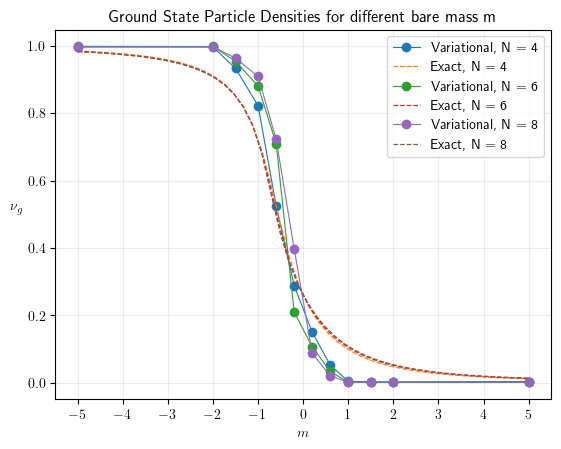

In [113]:

fig, ax = plt.subplots()
for i in range(len(num_sites)):
    ax.plot(masses, particle_densities[i], '.-', linewidth=0.8, markersize=12, label=f'Variational, N = {num_sites[i]}')
    ax.plot(masses_e, particle_densities_e[i], '--', linewidth=0.9, label=f'Exact, N = {num_sites[i]}')
ax.set_xticks(np.linspace(-5, 5, 11))
ax.set_xlabel(r"$m$")
ax.set_ylabel(r"$\nu_g$")
ax.yaxis.label.set(rotation='horizontal', ha='right')
ax.set_title("Ground State Particle Densities for different bare mass m")
ax.legend(loc='best')

plt.grid(True, alpha=0.25)

In [22]:
order_parameters_e = []
for i in range(len(num_sites)):
    order_parameter_op = get_order_parameter(num_sites[i])
    ground_states = states_e[i]
    order_parameters_e.append([order_parameter_op.expectation_value(statevector(state)) for state in ground_states])

In [23]:
order_parameters = []
for i in range(len(num_sites)):
    order_parameter_op = get_order_parameter(num_sites[i])
    ground_states = states[i]
    order_parameters.append([order_parameter_op.expectation_value(statevector(state)) for state in ground_states])

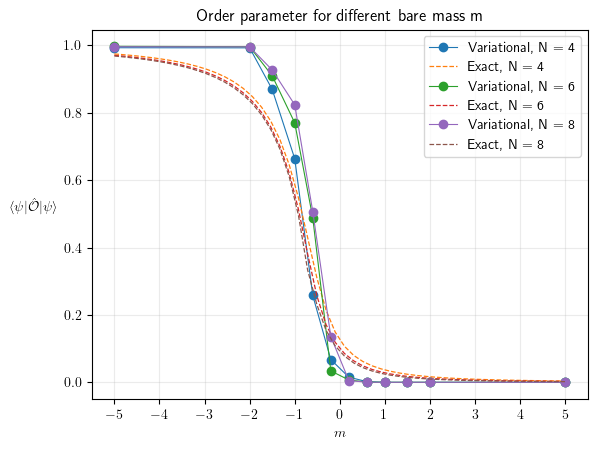

In [109]:

fig, ax = plt.subplots()
for i in range(len(num_sites)):
    ax.plot(masses, order_parameters[i], '.-', linewidth=0.8, markersize=12, label=f'Variational, N = {num_sites[i]}')
    ax.plot(masses_e, order_parameters_e[i], '--', linewidth=0.9, markersize=12, label=f'Exact, N = {num_sites[i]}')
ax.set_xticks(np.linspace(-5, 5, 11))
ax.set_xlabel("$m$")
ax.set_ylabel(r"$\langle \psi | \hat{\mathcal{O}} | \psi \rangle$")
ax.yaxis.label.set(rotation='horizontal', ha='right')
ax.set_title("Order parameter for different bare mass m")
ax.legend(loc='best')

plt.grid(True, alpha=0.25)

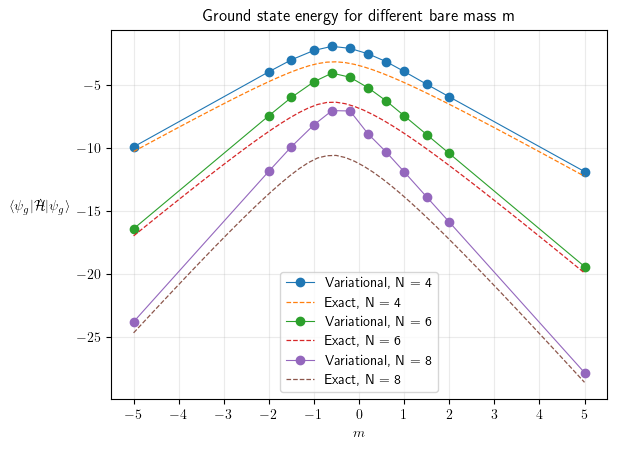

In [107]:
fig, ax = plt.subplots()
for i in range(len(num_sites)):
    ax.plot(masses, energies[i], '.-', linewidth=0.8, markersize=12, label=f'Variational, N = {num_sites[i]}')
    ax.plot(masses_e, energies_e[i], '--', linewidth=0.9, markersize=12, label=f' Exact, N = {num_sites[i]}')
ax.set_xticks(np.linspace(-5, 5, 11))
ax.set_xlabel(r"$m$")
ax.set_ylabel(r"$\langle \psi_g | \mathcal{\hat{H}} | \psi_g \rangle$")
ax.yaxis.label.set(rotation='horizontal', ha='right')
ax.set_title("Ground state energy for different bare mass m")
ax.legend(loc='best')

plt.grid(True, alpha=0.25)

In [ ]:
entanglement_e = []
for i in range(len(num_sites)):
    ground_states_e = states_e[i]
    entanglement_e.append([half_chain_entanglement_entropy(statevector(np.reshape(state, (state.size, 1)))) for state in ground_states_e])

In [ ]:
entanglement = []
for i in range(len(num_sites)):
    ground_states = states[i]
    entanglement.append([half_chain_entanglement_entropy(statevector(state)) for state in ground_states])

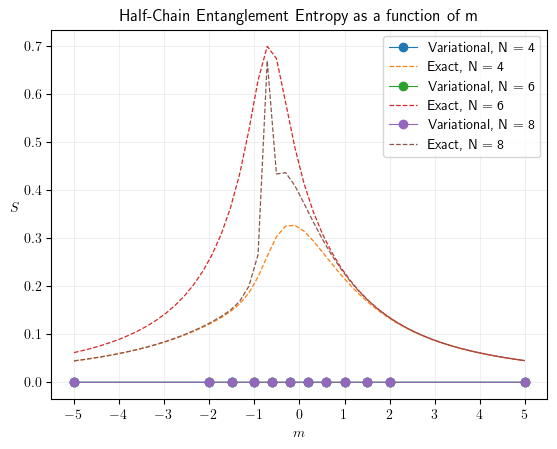

In [101]:
fig, ax = plt.subplots()
for i in range(len(num_sites)):
    ax.plot(masses, entanglement[i], '.-', linewidth=0.8, markersize=12, label=f'Variational, N = {num_sites[i]}')
    ax.plot(masses_e, entanglement_e[i], '--', linewidth=0.9, markersize=12, label=f' Exact, N = {num_sites[i]}')
ax.set_xticks(np.linspace(-5, 5, 11))
ax.set_xlabel(r"$m$")
ax.set_ylabel(r"$S$")
ax.yaxis.label.set(rotation='horizontal', ha='right')
ax.set_title("Half-Chain Entanglement Entropy as a function of m")
ax.legend(loc='best')

plt.grid(True, alpha=0.2)

In [54]:
states_c = [] #states and energies to compare the variational method and exact diagonalisation
energies_c = []

for N in num_sites:
    states_c.append([])
    energies_c.append([])
    for m in masses:
        coeffs = (m, 1, 1)
        hamiltonian = get_hamiltonian(N, coeffs)
        energy, state = exact_diagonalisation(hamiltonian)
        states_c[-1].append(state)
        energies_c[-1].append(energy)

In [72]:
overlaps = []
for i in range(len(num_sites)):
    overlaps.append([])
    for exact_state, var_state in zip(states_c[i], states[i]):
        exact_state = statevector(exact_state)
        var_state = statevector(var_state)
        overlap = abs((var_state.H()@exact_state))
        overlaps[-1].append(overlap[0])

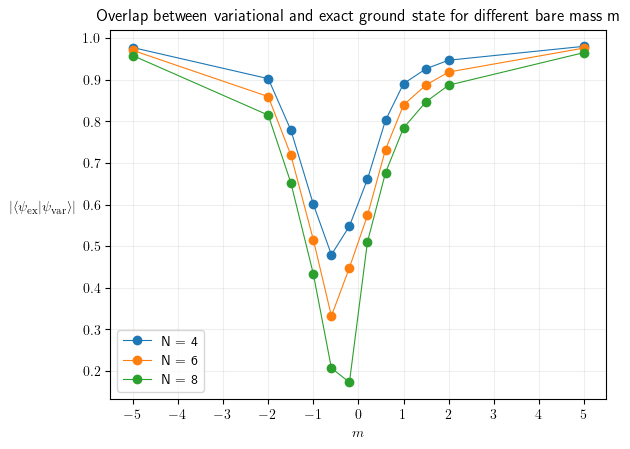

In [99]:
fig, ax = plt.subplots()
for i in range(len(num_sites)):
    ax.plot(masses, overlaps[i], '.-', linewidth=0.8, markersize=12, label=f'N = {num_sites[i]}')
ax.set_xticks(np.linspace(-5, 5, 11))
ax.set_xlabel(r"$m$")
ax.set_ylabel(r"$|\langle \psi_{\mathrm{ex}} | \psi_{\mathrm{var}} \rangle|$")
ax.yaxis.label.set(rotation='horizontal', ha='right')
ax.set_title("Overlap between variational and exact ground state for different bare mass m")
ax.legend(loc='best')

plt.grid(True, alpha=0.2)

In [79]:
perc_energy_diffs = []
for i in range(len(num_sites)):
    perc_energy_diffs.append([])
    for e_e, e_v in zip(energies_c[i], energies[i]):
        perc_energy_diffs[i].append(100*abs(e_e - e_v) / abs(e_e))

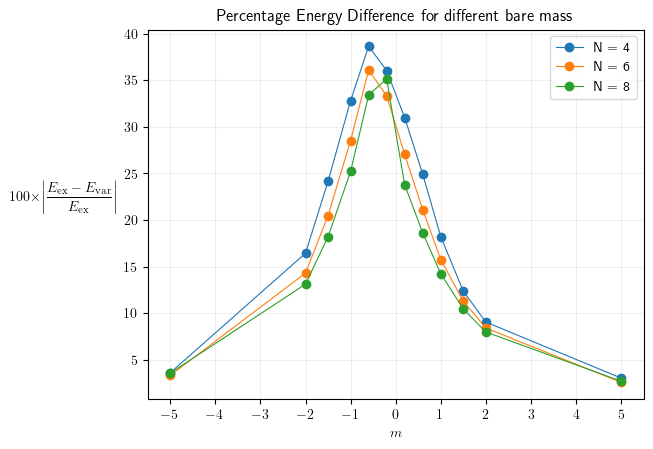

In [98]:
fig, ax = plt.subplots()
for i in range(len(num_sites)):
    ax.plot(masses, perc_energy_diffs[i], '.-', linewidth=0.8, markersize=12, label=f'N = {num_sites[i]}')
ax.set_xticks(np.linspace(-5, 5, 11))
ax.set_xlabel(r"$m$")
ax.set_ylabel(r"$100\times \biggr | \displaystyle \frac{E_{\mathrm{ex}} - E_{\mathrm{var}}}{E_{\mathrm{ex}}} \biggr |$")
ax.set_title("Percentage Energy Difference for different bare mass")
ax.yaxis.label.set(rotation='horizontal', ha='right')
ax.legend(loc='best')

plt.grid(True, alpha=0.2)